In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc("font", family="serif", size=13)
rc("text", usetex=True)
import daft
%matplotlib inline
#WIP

[1] https://en.wikipedia.org/wiki/Bayesian_network

[2] http://daft-pgm.org/

[3] Artificial Intelligence A Modern Approach (3rd Edition)

1. Bayes Theorem
2. Joint distribution that are intractable -> infuse domain knowledge to create graphical model.
3. Bayes Net
4. Computationally efficient to compute different probabilities
5. Law of Total Probability
6. Marginilization
7. Example 
8. Markov Blanket
9. D-separation
10. finish with bayes net applied to classification problem (y, X, weights)


Sampling
1. gibbs sampling
2. MH sampling
3. Hamiltonian Monte Carlo

### What is bayes theorem?

To understand Bayes theorem, lets start with the joint distribution between randome variables \\(Y\\), which will designate as the cause, \\(X\\), as the effect. The variables are binary taking on values of either \\(0\\) or\\(1\\). \\[P(X,Y)\\]

We can factor, or break apart, the joint in two different ways. \\[P(X,Y) = P(X|Y) P(Y) = P(Y|X)P(X)\\]

Thus in order to determine, \\(P(Y|X)\\), the probability of the cause, given the effect, we can reorder the above, to obtain \\[\frac{P(X|Y)P(Y)}{P(X)} = P(Y|X)\\]

The above is often shown as \\[\frac{(Likelihood)*(Prior)}{(Normalization)} = (Posterior)\\] 

Essentially, we are updating our prior belief of \\(Y\\) represented as \\(P(Y)\\) by the liklihood effect given the cause divided by some constant to arrive upon a new belief of \\(Y\\) given \\(X\\).


### Joint distributions are hard to deal with...

Most often times the joint distribution is not practical to compute. Lets consider a set of random variables, consisting of 2 random binary variables, \\((X,Y)\\), again. We know that there are 4 possible outcomes, \\((0,0), (1,0), (0,1), (1,1)\\), thus we can easily compute the joint probability of \\(P(X=1, Y=0)\\) as \\(0.25\\). This was easy as we knew how many outcomes aligned with \\(X=1\\) and \\(Y=0\\) and also the set of all possible outcomes.

Where is the difficult part? Well now consider a set of 20 random binary variables. To set of all possible outcomes is 2^20-1 or 1,048,575 combinations. Now consider random variables taking on an arbitrary number of values. You can quickly see how the "all possible outcomes" becomes difficult.

Ok...but Bayes Theorem has doesnt contain the joint distribution. Well in fact it does, its just been hidden away. For example, consider the liklihood, \\(P(X|Y)\\), which breaks down to \\(\frac{P(X,Y)}{P(Y)}\\). The joint has resurfaced.

The point is that the joint distribution often represents an obstacle, which has resulted in the development of abstractions that help to address the intractability of some joint distributions.

### Bayes Net and Graphical Models

Graphical models are ways to address the computation load of some joint distributions by introducing domain experties in the form of cause and effect relationships. 

**"A Bayesian network, Bayes network, belief network, Bayes(ian) model or probabilistic directed acyclic graphical model is a probabilistic graphical model (a type of statistical model) that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG)."**- Wiki[1]

**"The first is to see the network as a representation of the joint probability distribution.  The second is to view
it as an encoding of a collection of conditional independence statements."** - AIMA [2]

Said simply its a graphical model defining conditional relationships between random variables, with connecting arrows (not bi-directional as its acyclic (not cyclical)) usually in the arrows flowing from causes to effects.

Sticking with the example from Wikipedia, lets work with a small graphical model represented by a set of three random boolean variables, \\(s\\), \\(rain\\), \\(wet\\), where \\(s\\) stands for sprinkler.

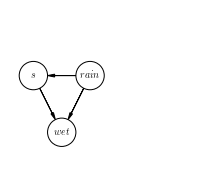

In [2]:
# NOTE: Daft [2] is a great library to visualize graphical models! 
# Instantiate the PGM.
pgm = daft.PGM([3.3, 3.05], origin=[0.1, 0.1])

# Add nodes
pgm.add_node(daft.Node("s", r"$s$", 0.5, 2))
pgm.add_node(daft.Node("rain", r"$rain$", 1.5, 2))
pgm.add_node(daft.Node("wet", r"$wet$", 1, 1))

# Add in the edges.
pgm.add_edge("rain","s")
pgm.add_edge("s", "wet")
pgm.add_edge("rain", "wet")

pgm.render()

#### In words
The probabilities that this graphical represents is as follows:  \\(P(s|rain)\\), the probability of a given state of the sprinkler given whether it rains or not,  \\(P(rain)\\), the probability of whether it rains or not, and \\(P(wet|s, rain)\\), the probability that its wet, given the state of the sprinkler and whether it rains or not.

#### Conditional Probability Table(CPT)
We can derive a CPT, conditional probability table, from the graphical model. This is where the domain knowledge comes into play as the CPT is typically provided.

Lets assume the below CPT (I set the probabilities using some common sense):

\begin{array}{rr}
P(s|r) \\ \hline
r & s &0.1  \\ \hline
r & \neg s &0.9  \\ \hline
\neg r &s &0.7  \\ \hline
\neg r &\neg s &0.3\\ \hline
\end{array}

\begin{array}{rr}
P(r) \\ \hline
r  &0.3 \\ \hline
\neg r  &0.7  \\ \hline
\end{array}

\begin{array}{rr}
P(w|s,r) \\ \hline
r & s & w & 0.99 \\ \hline
r & s & \neg w &0.01  \\ \hline
r & \neg s &  w &0.98  \\ \hline
r & \neg s & \neg w &0.02 \\ \hline
\neg r & s & w & 0.8 \\ \hline
\neg r & s & \neg w &0.2  \\ \hline
\neg r & \neg s &  w &0.05  \\ \hline
\neg r & \neg s & \neg w &0.95  \\ \hline
\end{array}

#### Example: Probability that its not raining given the evidence that the sprinkler is on and its not wet.
\\(P(\neg r | s, \neg w) =\\)

\\(\frac{P(\neg r, s, \neg w)}{P(s,\neg w)}\\) [ Apply chain rule and reorder. ]

\\(= \frac{P(\neg r, s, \neg w)}{\sum_r P(r=r,s,\neg w)}\\) [ Marginalize the denominator for all values of \\(r\\). ]

\\(= \frac{P(\neg r)P(s|\neg r)P(\neg w|s,\neg r)}{\sum_r P(r=r)P(s|r=r)P(\neg w|s,r=r)}\\) [ Factor using the CPT. ]

\\(= \frac{P(\neg r)P(s|\neg r)P(\neg w|s,\neg r)}{\sum_r P(r=r)P(s|r=r)P(\neg w|s,r=r)}\\) [ Move terms not dependent on \\(r\\) out of the summation, in this case no simplification! ]

\\(= \frac{P(\neg r)P(s|\neg r)P(\neg w|s,\neg r)}{P(r)P(s|r)P(\neg w|s,r) +  P(\neg r)P(s|\neg r)P(\neg w|s,\neg r)}\\) [ Expand. ]

\\(= \frac{(0.7)(0.7)(0.2)}{(0.3)(0.1)(0.01) +  (0.7)(0.7)(0.2)}\\) [ Plug in values based on CPT, the domain knowledge. ]

\\(= 0.996948\\)

This value seems reasonable, as we would expect that it was not raining if the sprinkler was on in addition if the grass was not wet.





### Markov Blanket

Markov blanket for a node in a Bayesian Network is a set of nodes that consists of the nodes parents, children, and childrens parents.

The Markov Blanket is a powerful tool in reducing the computational load. 

**"The Markov blanket of a node contains all the variables that shield the node from the rest of the network. This means that the Markov blanket of a node is the only knowledge needed to predict the behavior of that node."** - Wiki

Mathematically, \\[P(A|MB(A),B) = P(A|MB(A))\\]
where \\(MB(A)\\) is the Markov Blanket of A

Resources:
1. https://en.wikipedia.org/wiki/Markov_blanket

### D-separation

Rule 1: x and y are d-connected if there is an unblocked path between them. 

Rule 2: x and y are d-connected, conditioned on a set Z of nodes, if there is a collider-free path between x and y that traverses no member of Z. If no such path exists, we say that x and y are d-separated by Z, We also say then that every path between x and y is "blocked" by Z. 
 
Rule 3: If a collider is a member of the conditioning set Z, or has a descendant in Z, then it no longer blocks any path that traces this collider. 

*In summary, the introduction of knowledge **kills dependence** in the case of Rule 1 and Rule 2, while knowledge results in dependence in the case of Rule 3.*

e.g. \\(P(C | A,B) = P(C | B)\\) is really asking if \\(C\\) is orthogonal to \\(A\\) given \\(B\\). If all paths are destroyed by this knowledge then \\(C\\) and \\(A\\) are independent and the equivalence holds. If a path is created, for example, if \\(B\\) is the point of collision on a path between \\(A\\) and \\(C\\), then \\(A\\) and \\(C\\) are not independent and the equivalence does not hold.

Resources:
1. http://bayes.cs.ucla.edu/BOOK-2K/d-sep.html
2. https://www.andrew.cmu.edu/user/scheines/tutor/d-sep.html

In [1]:
#WIP